<h1 align='center'><u>Sentiment Analysis on IMDB dataset</u></h1>



* We will create 3 pipelines:
    1. Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model pipeline
    2. Feature Engineering + ML Model pipeline
    3. Feature Engineering + Data Preprocessing + Sparse Embeddings(TF-IDF) + ML Model pipeline.

## Installing/Importing libraries

In [7]:
!pip install bs4

In [8]:
!pip install -U spacy

  Using cached spacy-3.2.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.0 MB)
     |████████████████████████████████| 451 kB 5.2 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Using cached pydantic-1.8.2-cp37-cp37m-manylinux2014_x86_64.whl (10.1 MB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached thinc-8.0.13-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (628 kB)
  Using cached spacy_loggers-1.0.1-py3-none-any.whl (7.0 kB)
  Using cached typer-0.4.0-py3-none-any.whl (27 kB)
  Using cached catalogue-2.0.6-py3-none-any.whl (17 kB)
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Unins

In [40]:
# Import Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import textwrap as tw
import matplotlib.pyplot as plt

# learning Curves
from sklearn.model_selection import learning_curve

# save and load models
import joblib

import re
from bs4 import BeautifulSoup
import spacy

#from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline



In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
spacy.__version__

'3.2.1'

In [27]:
data_folder = Path('/content/drive/MyDrive/Data/NLP')
#data_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/Data/NLP')

In [16]:
model_folder = Path('/content/drive/MyDrive/teaching_spring_2022/Models')
#model_folder = Path('/home/harpreet/Insync/harpreet24.utd@gmail.com/teaching_spring_2022/Models')

In [17]:
#!mkdir {str(model_folder /'NLP')}

In [18]:
!python -m spacy download 'en_core_web_sm'

     |████████████████████████████████| 13.9 MB 4.7 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [21]:
# load spacy model
nlp = spacy.load('en_core_web_sm')

In [22]:
import sys
sys.path.append('/content/drive/MyDrive/Custom_functions')
#sys.path.append('/home/harpreet/Insync/google_drive_shaannoor/Custom_functions')

In [23]:
import custom_preprocessor as cp
from  plot_learning_curve import plot_learning_curve

## 2. Loading the dataset

For this notebook, we will use IMDB movie review dataset. <br>
LInk for complete dataset: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz.

We downloaded the dataset in the previous lecture (notebook: 10_Faster_tokenization_spacy_final.ipynb)

We will now use the saved train.csv and test.csv file.

In [28]:
# location of train and test files
train_file = data_folder / 'movie_review_data'/'train.csv'
test_file = data_folder / 'movie_review_data'/'test.csv'

In [29]:
# creating Pandas Dataframe
train_data = pd.read_csv(train_file, index_col=0)
test_data = pd.read_csv(test_file, index_col=0)

In [30]:
# print shape of the datasets
print(f'Shape of Training data set is : {train_data.shape}')
print(f'Shape of Test data set is : {test_data.shape}')

Shape of Training data set is : (25000, 2)
Shape of Test data set is : (25000, 2)


In [31]:
#Printing top 5 train records
train_data.head()

,Reviews,Labels
0,Ever wanted to know just how much Hollywood co...,1
1,The movie itself was ok for the kids. But I go...,1
2,You could stage a version of Charles Dickens' ...,1
3,this was a fantastic episode. i saw a clip fro...,1
4,and laugh out loud funny in many scenes.<br />...,1


In [32]:
#Printing top 5 test records
test_data.head()

,Reviews,Labels
0,THE SEA INSIDE a film by Alejandro Amenabar.<b...,1
1,After World War II the ungoing crime in Phenix...,1
2,"""Pitch Black"" was a complete shock to me when ...",1
3,This film is an excellent teaching tool as a p...,1
4,"Sweet, rich valley girl develops crush on a pu...",1


In [33]:
train_smaller = train_data.sample(frac=0.1, replace=True, random_state=1)

In [34]:
test_smaller = test_data.sample(frac=0.1, replace=True, random_state=1)

## 3. Exploratory Data Analysis

In [35]:
# Printing basic info
train_smaller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 235 to 21762
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Reviews  2500 non-null   object
 1   Labels   2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 58.6+ KB


In [36]:
# Checking distribution of class labels for train dataset
train_smaller['Labels'].value_counts()

1    1286
0    1214
Name: Labels, dtype: int64

In [37]:
# Checking distribution of class labels for test dataset
test_smaller['Labels'].value_counts()

1    1286
0    1214
Name: Labels, dtype: int64

As we can see our data is well balannced.

## 4. Classification Pipeline

### Train-Test Split

In [38]:
X_train, X_test, y_train, y_test = train_smaller['Reviews'].values, test_smaller['Reviews'].values, train_smaller['Labels'].values, test_smaller['Labels'].values

print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (2500,) y_train: (2500,)
X_test: (2500,) y_test: (2500,)


### Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model pipeline

#### Preprocessing as part of pipeline
-- preprocessor --> TFidf Vectorizer --> Logistic Regression

In [41]:
classifier_1 = Pipeline([('preprocessor', cp.SpacyPreprocessor(model = 'en_core_web_sm',remove_stop=False)),
                  ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                 
                  ('classifier', LogisticRegression()),
                 ])

In [42]:
# We have used default valus for all parameters except for lammetizer
# Ideally we can specify range of values for all parameters
# If the search space is very large then we should use RandomSerachCV
# use following hyperparameters -- vectorizer max_feattures -- 1000, vectorizer --max_df --0.8, classifier C [0.1, 1]

param_grid_classifier_1 = {'preprocessor__lammetize' : [True, False],
                'vectorizer__max_features': [1000],
                'vectorizer__max_df': [0.8],
                'classifier__C': [0.1, 1]}

In [43]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 2, just for demonstration.

grid_classifier_1 = GridSearchCV(estimator=classifier_1, param_grid=param_grid_classifier_1, cv = 2)

In [44]:
# Fit the model on training data
# This cell will take up to 5 minutes
grid_classifier_1.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        SpacyPreprocessor(model='en_core_web_sm',
                                                          remove_stop=False)),
                                       ('vectorizer',
                                        TfidfVectorizer(token_pattern='[\\S]+')),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1],
                         'preprocessor__lammetize': [True, False],
                         'vectorizer__max_df': [0.8],
                         'vectorizer__max_features': [1000]})

In [45]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1.best_score_))
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest Estimator ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.83

Best parameters:  {'classifier__C': 1, 'preprocessor__lammetize': True, 'vectorizer__max_df': 0.8, 'vectorizer__max_features': 1000}

Best Estimator  Pipeline(steps=[('preprocessor',
                 SpacyPreprocessor(model='en_core_web_sm', remove_stop=False)),
                ('vectorizer',
                 TfidfVectorizer(max_df=0.8, max_features=1000,
                                 token_pattern='[\\S]+')),
                ('classifier', LogisticRegression(C=1))])


In [46]:
# Accuracy on Train data set
grid_classifier_1_train_score = grid_classifier_1.score(X_train, y_train)
print(f'Accuracy on train set is {grid_classifier_1_train_score}')

Accuracy on train set is 0.9088


#### Pre-processing as a separate step

In [47]:
# Step 1: Preprocessing
X_train_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_train)

In [48]:
classifier_1a = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                         ('classifier', LogisticRegression(max_iter = 10000)),
                        ])

In [49]:
# We have used default valus for all parameters except for lammetizer
# Ideally we can specify range of values for all parameters
# If the search space is very large then we should use RandomSerachCV

param_grid_classifier_1a = {'vectorizer__max_features': [500, 1000, 2000, None],
                           'vectorizer__max_df': [0.8, 0.6, 0.4],
                           'classifier__C': [0.1, 1, 10]}

In [50]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_1a = GridSearchCV(estimator=classifier_1a, param_grid=param_grid_classifier_1a, cv = 3)

In [51]:
# Fit the model on training data
grid_classifier_1a.fit(X_train_cleaned, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(token_pattern='[\\S]+')),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'vectorizer__max_df': [0.8, 0.6, 0.4],
                         'vectorizer__max_features': [500, 1000, 2000, None]})

In [52]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1a.best_score_))
print("\nBest parameters: ", grid_classifier_1a.best_params_)
print("\nBest estimator: ", grid_classifier_1a.best_estimator_)

Best cross-validation score: 0.86

Best parameters:  {'classifier__C': 10, 'vectorizer__max_df': 0.8, 'vectorizer__max_features': None}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.8, token_pattern='[\\S]+')),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])


In [53]:
file_model_sparse_embed = model_folder / 'sparse_embed_model.pkl'

In [54]:
joblib.dump(grid_classifier_1a.best_estimator_, file_model_sparse_embed)

['/content/drive/MyDrive/teaching_spring_2022/Models/sparse_embed_model.pkl']

In [55]:
# load the saved model
loaded_model_sparse_embed = joblib.load(file_model_sparse_embed)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

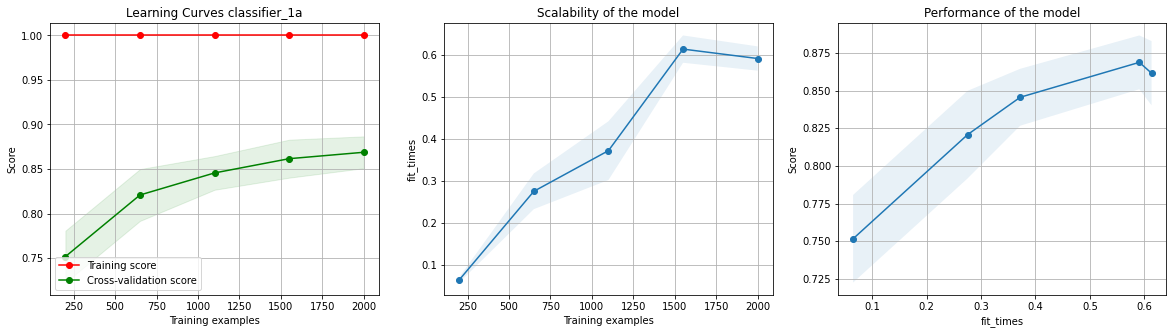

In [56]:
# plot learning curces
# This cell can take upto 30 minutes to run
plot_learning_curve(loaded_model_sparse_embed, 'Learning Curves classifier_1a', X_train_cleaned, y_train)

**Observations**
<br>
Clearly there is overfitting. In case of overfitting we can improve results by 

1. Adding more data (training model on complete dataset)
2. By hyperparameter tuning (reduce model complexity) of logistic regression and vectorizer.

In [57]:
# Accuracy on Train data set
grid_classifier_sparse_embed = loaded_model_sparse_embed.score(X_train_cleaned, y_train)
print(f'Accuracy on train set  is {grid_classifier_sparse_embed}')

Accuracy on train set  is 1.0


## Evaluate model on test datset

In [58]:
# Final Pipeline
def final_pipeline(text):
  cleaned_text = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(text)
  predictions = loaded_model_sparse_embed.predict(cleaned_text)
  return predictions

In [59]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

#### Classification report for test dataset

* As we have already seen, our dataset is well balanced. Hence we have used accuracy as our scoring method.
* However, it is a good idea to also look at classification report which gives precision, recall, and f1-score for both labels and average score also.
* This metric works very well in case of balanced as well as imbalanced data because it lets you measure the performance of model for each labels.

In [60]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.85      0.84      0.84      1214
           1       0.85      0.86      0.85      1286

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500

